In [16]:
import os
import json
from PIL import Image
import os
import json
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
def load_train_data(dataset_path):
    """
    Loads image paths and annotations from only the training dataset.

    Args:
        dataset_path (str): Path to the main dataset directory

    Returns:
        tuple: (image_paths, annotations) - Lists of image file paths and annotation data
    """
    image_paths = []
    annotations = []

    # Only process train split
    img_dir = os.path.join(dataset_path, 'train', 'img')
    ann_dir = os.path.join(dataset_path, 'train', 'ann')

    # Ensure directories exist
    if not os.path.exists(img_dir) or not os.path.exists(ann_dir):
        print(f"Error: Directory {img_dir} or {ann_dir} not found.")
        return image_paths, annotations

    for filename in os.listdir(img_dir):
        if filename.endswith('.jpg'):
            image_path = os.path.join(img_dir, filename)
            annotation_path = os.path.join(ann_dir, filename + '.json')

            if os.path.exists(annotation_path):
                try:
                    with open(annotation_path, 'r') as f:
                        annotation = json.load(f)
                    image_paths.append(image_path)
                    annotations.append(annotation)
                except json.JSONDecodeError:
                    print(f"Error: Invalid JSON in {annotation_path}")
            else:
                print(f"Warning: No annotation found for {filename}")

    return image_paths, annotations

# Example Usage
if __name__ == '__main__':
    dataset_root = '/Users/spgohil/Developer/Projects/ROAD-CONDITION-DETECTION/dataset/DatasetNinja_RDD2022_MIX/'
    
    image_paths, annotations = load_train_data(dataset_root)
    
    print(f"Loaded {len(image_paths)} training images and {len(annotations)} annotations.")
    
    # Example: Print the first image path and its annotation
    if image_paths:
        print(f"First image path: {image_paths[0]}")
        print(f"First annotation: {annotations[0]}")

Loaded 804 training images and 804 annotations.
First image path: /Users/spgohil/Developer/Projects/ROAD-CONDITION-DETECTION/dataset/DatasetNinja_RDD2022_MIX/train/img/Japan_005850.jpg
First annotation: {'description': '', 'tags': [{'id': 16552613, 'tagId': 29663, 'name': 'Japan', 'value': None, 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.633Z', 'updatedAt': '2024-01-22T15:32:59.633Z'}], 'size': {'height': 600, 'width': 600}, 'objects': [{'id': 138956045, 'classId': 6512000, 'objectId': None, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.634Z', 'updatedAt': '2024-01-22T15:32:59.634Z', 'tags': [{'id': 104942971, 'tagId': 29666, 'name': 'detail', 'value': 'equal interval', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.634Z', 'updatedAt': '2024-01-22T15:32:59.634Z'}], 'classTitle': 'transverse crack', 'points': {'exterior': [[250, 352], [522, 388]], '

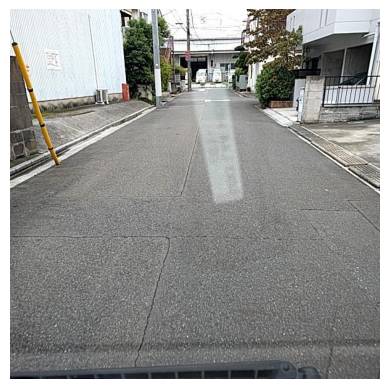

First Annotation: {'description': '', 'tags': [{'id': 16552613, 'tagId': 29663, 'name': 'Japan', 'value': None, 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.633Z', 'updatedAt': '2024-01-22T15:32:59.633Z'}], 'size': {'height': 600, 'width': 600}, 'objects': [{'id': 138956045, 'classId': 6512000, 'objectId': None, 'description': '', 'geometryType': 'rectangle', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.634Z', 'updatedAt': '2024-01-22T15:32:59.634Z', 'tags': [{'id': 104942971, 'tagId': 29666, 'name': 'detail', 'value': 'equal interval', 'labelerLogin': 'inbox@datasetninja.com', 'createdAt': '2024-01-22T15:32:59.634Z', 'updatedAt': '2024-01-22T15:32:59.634Z'}], 'classTitle': 'transverse crack', 'points': {'exterior': [[250, 352], [522, 388]], 'interior': []}}]}


In [10]:
if image_paths:
    img = Image.open(image_paths[0])
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(f"First Annotation: {annotations[0]}")
else:
    print("No images found in dataset.")

class MyDataset(torchvision.datasets.ImageFolder):

def __init__(self, train_folder_path='.', transform=None, target_transform=None):
    super().__init__(train_folder_path, transform, target_transform)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [12]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, image_paths, annotations, transform=None):
        self.image_paths = image_paths
        self.annotations = annotations
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        annotation = self.annotations[idx]
        
        if self.transform:
            img = self.transform(img)
        
        return img, annotation


In [13]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])


In [14]:
# Create dataset and dataloader
dataset = ObjectDetectionDataset(image_paths, annotations, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

In [17]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    model.to(device)
    model.train()
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for images, labels in dataloader:
            images = images.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.tensor([label for label in labels]).to(device))
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

# Load pre-trained model (YOLO or RCNN based)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_model(model, dataloader, criterion, optimizer, num_epochs=5)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/spgohil/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>